In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import cv2
import pathlib
import os
import random
from skimage.io import imread
import horovod.tensorflow as hvd
hvd.init()

W0801 23:49:00.014795 4649584064 module_wrapper.py:139] From /Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/horovod/tensorflow/__init__.py:117: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0801 23:49:00.015830 4649584064 module_wrapper.py:139] From /Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/horovod/tensorflow/__init__.py:143: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
def model_x(x, keep_prob=1.0):  #VGG-Face-Lite   
    #   
    # weights
    conv1_1_filter = tf.Variable(tf.random_normal(shape=[3, 3, 3, 64], mean=0, stddev=10e-2)) # third param is RGB, so 3
    conv1_2_filter = tf.Variable(tf.random_normal(shape=[3, 3, 64, 64], mean=0, stddev=10e-2)) 
    conv2_1_filter = tf.Variable(tf.random_normal(shape=[3, 3, 64, 128], mean=0, stddev=10e-2))
    conv2_2_filter = tf.Variable(tf.random_normal(shape=[3, 3, 128, 128], mean=0, stddev=10e-2))
    conv3_1_filter = tf.Variable(tf.random_normal(shape=[3, 3, 128, 256], mean=0, stddev=10e-2))
    conv3_2_filter = tf.Variable(tf.random_normal(shape=[3, 3, 256, 256], mean=0, stddev=10e-2))
    conv3_3_filter = tf.Variable(tf.random_normal(shape=[3, 3, 256, 256], mean=0, stddev=10e-2))
    conv4_1_filter = tf.Variable(tf.random_normal(shape=[3, 3, 256, 512], mean=0, stddev=10e-2))    
    conv4_2_filter = tf.Variable(tf.random_normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))
    conv4_3_filter = tf.Variable(tf.random_normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))
    conv5_1_filter = tf.Variable(tf.random_normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))    
    conv5_2_filter = tf.Variable(tf.random_normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))
    conv5_3_filter = tf.Variable(tf.random_normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))

    # 1, 2, 3, 4, 5, 6
    conv1_1 = tf.nn.conv2d(x, conv1_1_filter, strides=[1,1,1,1], padding='SAME')
    conv1_1 = tf.nn.relu(conv1_1)
    conv1_2 = tf.nn.conv2d(conv1_1, conv1_2_filter, strides=[1,1,1,1], padding='SAME')
    conv1_2 = tf.nn.relu(conv1_2)
    conv1_pool = tf.nn.max_pool(conv1_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 7, 8, 9, 10, 11, 12
    conv2_1 = tf.nn.conv2d(conv1_bn, conv2_1_filter, strides=[1,1,1,1], padding='SAME')
    conv2_1 = tf.nn.relu(conv2_1)
    conv2_2 = tf.nn.conv2d(conv2_1, conv2_2_filter, strides=[1,1,1,1], padding='SAME')
    conv2_2 = tf.nn.relu(conv2_2)
    conv2_pool = tf.nn.max_pool(conv2_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 13, 14, 15, 16, 17, 18
    conv3_1 = tf.nn.conv2d(conv2_pool, conv3_1_filter, strides=[1,1,1,1], padding='SAME')
    conv3_1 = tf.nn.relu(conv3_1)
    conv3_2 = tf.nn.conv2d(conv3_1, conv3_2_filter, strides=[1,1,1,1], padding='SAME')
    conv3_2 = tf.nn.relu(conv3_2)
    conv3_3 = tf.nn.conv2d(conv3_2, conv3_3_filter, strides=[1,1,1,1], padding='SAME')
    conv3_3 = tf.nn.relu(conv3_3)
    conv3_pool = tf.nn.max_pool(conv3_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') 
    conv3_bn = tf.layers.batch_normalization(conv3_pool)

    conv4_1 = tf.nn.conv2d(conv3_bn, conv4_1_filter, strides=[1,1,1,1], padding='SAME')
    conv4_1 = tf.nn.relu(conv4_1)
    conv4_2 = tf.nn.conv2d(conv4_1, conv4_2_filter, strides=[1,1,1,1], padding='SAME')
    conv4_2 = tf.nn.relu(conv4_2)
    conv4_3 = tf.nn.conv2d(conv4_2, conv4_3_filter, strides=[1,1,1,1], padding='SAME')
    conv4_3 = tf.nn.relu(conv4_3)
    conv4_pool = tf.nn.max_pool(conv4_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') 
    conv4_bn = tf.layers.batch_normalization(conv4_pool)

    conv5_1 = tf.nn.conv2d(conv4_bn, conv5_1_filter, strides=[1,1,1,1], padding='SAME')
    conv5_1 = tf.nn.relu(conv5_1)
    conv5_2 = tf.nn.conv2d(conv5_1, conv5_2_filter, strides=[1,1,1,1], padding='SAME')
    conv5_2 = tf.nn.relu(conv5_2)
    conv5_3 = tf.nn.conv2d(conv5_2, conv5_3_filter, strides=[1,1,1,1], padding='SAME')
    conv5_3 = tf.nn.relu(conv5_3)
    conv5_pool = tf.nn.max_pool(conv5_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') 
    conv5_bn = tf.layers.batch_normalization(conv5_pool)

       
    # 35
    flat = tf.contrib.layers.flatten(conv5_bn)  

    # 36, 37, 38
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=4096, activation_fn=tf.nn.relu) #fc6
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)

    out = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=len(label_names), activation_fn=None) #fc8
    
    logits = tf.identity(out, name='logits')
    
    return logits

In [4]:
def model_fn(features, labels, mode, params):
    model = model_x(features["input_img"])
    _,top_5 =  tf.nn.top_k(model,k=5)
    predictions = {
        'top_1': tf.argmax(model, -1),
        'top_5': top_5,
        'probabilities': tf.nn.softmax(model),
        'logits': model,
    }
    return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    

In [5]:
def predict(img_data):
    class_num, class_name, confidence = None, None, 0.
    with tf.Session(config=config) as sess:
        image = img_data
        im_data = tf.reshape(image, [1, IMAGE_SIZE, IMAGE_SIZE, 3])
        im_data = tf.cast(im_data, tf.float32)
        
        with tf.Session() as sess:
            im_data = im_data.eval()

        checkpoint_dir = '../models/vgg-models/checkpoints-1e3x4-2e4-09202019'            
        latest = tf.train.latest_checkpoint(checkpoint_dir)
        loader = tf.train.import_meta_graph(latest+'.meta')

        my_input_fn = tf.estimator.inputs.numpy_input_fn(
            x={"input_img": im_data},
            shuffle=False,
            batch_size=1)

        predictor = tf.estimator.Estimator(model_fn=model_fn, model_dir=checkpoint_dir)
        predictions = predictor.predict(input_fn=my_input_fn)
        
        final_result = None
        for result in predictions:
            final_result = result
            
        print(final_result["top_5"])
        logits_out = final_result["logits"]
        print(logits_out)

        class_num = np.argmax(logits_out, axis=0)
        class_name = label_names[class_num]
        confidence = logits_out[class_num]
        all_preds = logits_out
            
            
    return (class_num, class_name, confidence, all_preds)

In [6]:
def get_celeb_box(df, name, img_num):
    the_box_row = df.loc[df['CELEB']==name]
    the_box_row = the_box_row.iloc[img_num]
    return the_box_row[['LEFT', 'TOP', 'RIGHT', 'BOTTOM']].values

In [7]:
def get_celeb_url(df, name, img_num):
    the_url_row = df.loc[df['CELEB']==name].iloc[img_num]['URL']
    return the_url_row

In [8]:
def bbox_on_img(url, bbox):
    image = imread(url)
    plt.figure()
    plt.imshow(image)
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]
    
    w=x2-x1
    h=y2-y1
    rect = Rectangle((x1, y1), w, h, fill=False, color='r')
    plt.axes().add_patch(rect)
    plt.show()   

In [9]:
def get_clip_image(url, bbox):
    image = imread(url)
    
    x1 = int(bbox[0])
    y1 = int(bbox[1])
    x2 = int(bbox[2])
    y2 = int(bbox[3])
    
    w=x2-x1
    h=y2-y1
    
    crop_img = image[y1:y1+h, x1:x1+w]
    new_size = IMAGE_SIZE, IMAGE_SIZE
    crop_img = cv2.resize(crop_img, new_size, interpolation=cv2.INTER_CUBIC)
    #crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR)
    return crop_img

In [10]:
IMAGE_SIZE=64

In [11]:
data_root_orig = '../data/vgg-face'
data_root = pathlib.Path(data_root_orig)

In [12]:
celeb_root = pathlib.Path('../data/vgg_face_dataset/files/')
celebs_to_test = list(celeb_root.glob('*.txt'))
celebs_to_test = [str(c).split('.')[2].split('/')[4] for c in celebs_to_test]
#print(celebs_to_test)
print(len(celebs_to_test))

all_image_paths = []
for c in celebs_to_test:
    all_image_paths += list(data_root.glob(c+'/*')) 

all_image_paths_c = []
for p in all_image_paths:
    path_str = os.path.basename(str(p))
    if path_str.startswith('._'):
        print('Rejecting '+str(p))
    else:
        all_image_paths_c.append(p)

all_image_paths = all_image_paths_c
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

2622


1903

In [13]:
label_names = sorted(celebs_to_test)
label_names

['A',
 'A',
 'A_P_J_Abdul_Kalam',
 'Aamir_Khan',
 'Aaron_Staton',
 'Aaron_Tveit',
 'Aaron_Yoo',
 'Abbie_Cornish',
 'Abel_Ferrara',
 'Abigail_Breslin',
 'Abigail_Klein',
 'Abigail_Spencer',
 'Abraham_Benrubi',
 'Adam_Baldwin',
 'Adam_Beach',
 'Adam_Brody',
 'Adam_Buxton',
 'Adam_Copeland',
 'Adam_Driver',
 'Adam_G',
 'Adam_Garcia',
 'Adam_Godley',
 'Adam_Goldberg',
 'Adam_Gregory',
 'Adam_Hicks',
 'Adam_Lambert',
 'Adam_Levine',
 'Adam_Rodriguez',
 'Adelaide_Clemens',
 'Adelaide_Kane',
 'Adina_Porter',
 'Aditya_Roy_Kapoor',
 'Adrian_Grenier',
 'Adrian_Paul',
 'Adriana_Barraza',
 'Adrianne_Curry',
 'Adrianne_Palicki',
 'Adrienne_Barbeau',
 'Agyness_Deyn',
 'Aida_Turturro',
 'Aidan_Gillen',
 'Aidan_Turner',
 'Ajay_Devgn',
 'Akshay_Kumar',
 'Alain_Delon',
 'Alan_Alda',
 'Alan_Cumming',
 'Alan_Dale',
 'Alan_Ladd',
 'Alan_Rickman',
 'Alan_Tudyk',
 'Alba_Rohrwacher',
 'Aldis_Hodge',
 'Alessandra_Torresani',
 'Alex_Borstein',
 'Alex_Kingston',
 'Alex_Newell',
 'Alex_Pettyfer',
 'Alex_Trebek',


In [14]:
valid_face_urls_path = '../data/vgg_face_full_urls.csv'
face_urls_path = '../data/vgg_face_full.csv'

if not os.path.exists(valid_face_urls_path):  
    path = '../data/vgg_face_dataset/files'
    for (dirpath, dirnames, filenames) in os.walk(path):
        df = None
        for filename in tqdm(filenames):
            if filename.endswith('.txt'): 
                celeb_name = os.path.splitext(filename)[0]
                full_path = os.sep.join([dirpath, filename])
                #print("Processing: ["+celeb_name+"]: full path: ["+full_path+"]")
                if df is not None:
                    df = df.append(process_celeb(celeb_name,  full_path))
                else:
                    df = process_celeb(celeb_name, full_path)
    
    df.to_csv(face_urls_path)
    print('Num Celeb Images', str(len(df)))
else:
    # run the script vgg_valid_url.py and change n_cores to how many parallel proc you want validating the URLs
    # running this script will yield a new dataframe saved in the file that you are opening below with a new 
    # column, VALID_URL set to True if the result of requests.head(url, timeout=0.0001) is 200, else False
    df = pd.read_csv(valid_face_urls_path)   

Celeb Name Aamir_Khan
Pic Num 31
[48.84 97.34 194.01 242.51]
http://4.bp.blogspot.com/-n_1q2_waJlU/TV5Nv1TEIkI/AAAAAAAAeZs/axez0hRebvM/s1600/Aamir-Khan%2527s-next-two-Movie.jpg


/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


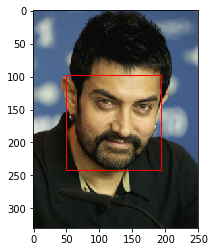

In [17]:
celeb_name = label_names[random.randint(0,3)]
c_num = random.randint(0,300)
print('Celeb Name', celeb_name)
print('Pic Num', c_num)
c_box =  get_celeb_box(df, celeb_name, c_num)
print(c_box)
c_url= get_celeb_url(df, celeb_name, c_num)
print(c_url)
bbox_on_img(c_url, c_box)

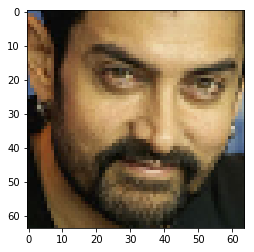

In [18]:
p_img = get_clip_image(c_url, c_box)
plt.figure()
plt.imshow(p_img)

In [19]:
class_num2, class_name2, confidence2, all_preds2 = predict(p_img)

W0801 23:49:30.056663 4649584064 model_fn.py:630] Estimator's model_fn (<function model_fn at 0x15159d048>) includes params argument, but params are not passed to Estimator.
W0801 23:49:30.066184 4649584064 deprecation.py:323] From /Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_queue_runner.py:62: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W0801 23:49:30.068310 4649584064 deprecation.py:323] From /Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_functions.py:500: add_queue_runner (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `t

[   3 2043  696 2021   46]
[  -8.636186   56.122963  -55.871487 ... -115.45098    74.11176
   59.08086 ]


In [20]:
print('Class_Num', class_num2)
print('Class_Name', class_name2)
print('Confidence', str(confidence2))
print(all_preds2)

print(label_names)

Class_Num 3
Class_Name Aamir_Khan
Confidence 432.33475
[  -8.636186   56.122963  -55.871487 ... -115.45098    74.11176
   59.08086 ]
['A', 'A', 'A_P_J_Abdul_Kalam', 'Aamir_Khan', 'Aaron_Staton', 'Aaron_Tveit', 'Aaron_Yoo', 'Abbie_Cornish', 'Abel_Ferrara', 'Abigail_Breslin', 'Abigail_Klein', 'Abigail_Spencer', 'Abraham_Benrubi', 'Adam_Baldwin', 'Adam_Beach', 'Adam_Brody', 'Adam_Buxton', 'Adam_Copeland', 'Adam_Driver', 'Adam_G', 'Adam_Garcia', 'Adam_Godley', 'Adam_Goldberg', 'Adam_Gregory', 'Adam_Hicks', 'Adam_Lambert', 'Adam_Levine', 'Adam_Rodriguez', 'Adelaide_Clemens', 'Adelaide_Kane', 'Adina_Porter', 'Aditya_Roy_Kapoor', 'Adrian_Grenier', 'Adrian_Paul', 'Adriana_Barraza', 'Adrianne_Curry', 'Adrianne_Palicki', 'Adrienne_Barbeau', 'Agyness_Deyn', 'Aida_Turturro', 'Aidan_Gillen', 'Aidan_Turner', 'Ajay_Devgn', 'Akshay_Kumar', 'Alain_Delon', 'Alan_Alda', 'Alan_Cumming', 'Alan_Dale', 'Alan_Ladd', 'Alan_Rickman', 'Alan_Tudyk', 'Alba_Rohrwacher', 'Aldis_Hodge', 'Alessandra_Torresani', 'Alex_